# CSC413 Lab 3: Multi-Layer Perceptrons with MedMNIST

MedMNIST's PneumoniaMNIST data set. We will now transition fully to
using PyTorch for our labs going forward.

By the end of this lab, you will be able to:

1. Build and train an MLP using PyTorch
2. Define the following performance metrics for evaluating machine learning models: true positive, true negative, false positive, false negative, precision, recall, ROC curve, and AUC.
3. Interpret the confusion matrix.
4. Explain the advantages of the AUC metrics over accuracy metrics.
5. Perform grid search to find hyperparameters.

Acknowledgements:

- The MedMNIST data is from https://medmnist.com/
- This assignment is written by Mahdi Haghifam, Sonya Allin, Lisa Zhang, Mike Pawliuk and Rutwa Engineer

Please work in groups of 1-2 during the lab.

## Submission

If you are working with a partner, start by creating a group on Markus. If you are working alone,
click "Working Alone".

Submit the ipynb file `lab03.ipynb` on Markus
**containing all your solutions to the Graded Task**s.
Your notebook file must contain your code **and outputs** where applicable,
including printed lines and images.
Your TA will not run your code for the purpose of grading.

For this lab, you should submit the following:

- Part 2. Your expression that computes the number of trainable parameters in the MLPModel (1 point)
- Part 2. Your implementation of `accuracy`. (1 point)
- Part 2. Your implementation of `train_model`. (2 points)
- Part 3. Your implementation of `precision` and `recall`. (2 points)
- Part 3. Your interpretation of the confusion matrix for `m_once` (1 point)
- Part 4. Your completion of the grid search, along with the output (2 point)
- Part 4. Your description of why a model with high AUC may still perform poorly for some groups (1 point)

In [110]:
import numpy as np
import matplotlib.pyplot as plt

## Google Colab Setup

We will be using the `medmnist` data set, which is available as a Python package.
Recall that on Google Colab, we use "!" to run shell commands.

In [111]:
!pip install medmnist

## Part 1. Data

We will use the MedMNIST data set, which is described here: [https://medmnist.com/](https://medmnist.com/).
We will use the PneumoniaMNIST images, which are greyscale chest X-ray images that has been resized to 28x28.
The task is to predict, given one of these X-ray images, whether the patient has pneumonia or not---a binary
classification task.
We chose this dataset both because it is lightweight, and because it allows us to discuss the sensitive nature of
biomedical images.

Let's begin by printing some information about the PneumoniaMNIST  data set:

In [112]:
import numpy as np
import matplotlib.pyplot as plt

import medmnist
from medmnist import PneumoniaMNIST

medmnist.INFO['pneumoniamnist']

{'python_class': 'PneumoniaMNIST',
 'description': 'The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.',
 'url': 'https://zenodo.org/records/10519652/files/pneumoniamnist.npz?download=1',
 'MD5': '28209eda62fecd6e6a2d98b1501bb15f',
 'url_64': 'https://zenodo.org/records/10519652/files/pneumoniamnist_64.npz?download=1',
 'MD5_64': '8f4eceb4ccffa70c672198ea285246c6',
 'url_128': 'https://zenodo.org/records/10519652/files/pneumoniamnist_128.npz?download=1',
 'MD5_128': '05b46931834c231683c68f40c47b2971',
 'url_224': 'https://zenodo.org/records/10519652/files/pneumoniamnist_224.npz?download=1',
 'MD5_224': 'd6a3c71de1b94

**Task**: The dataset providers already split the data into training, validation, and test sets.
How many samples are there in the training, validation, and test sets?

In [113]:
# TODO: 'train': 4708, 'val': 524, 'test': 624

Let's visually inspect the first element of the training data:

Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
389 135 524


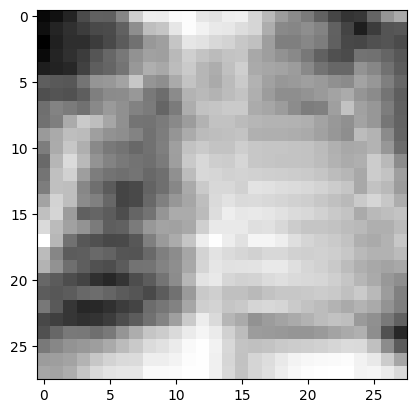

In [114]:
train_data_imgs = PneumoniaMNIST(split='val', download=True)
pos, neg, counter = 0, 0, 0
for img, target in train_data_imgs:
    plt.imshow(img, cmap='gray')
    #print(np.array(img)) # img is a numpy array of shape 28x28 , with integer values between 0-255
    #print(target)        # the target
    counter +=1
    if target == 1:
      pos += 1
    else:
      neg += 1
print(pos, neg, counter)

**Task**: Based on the code above, what is the type of the data structure `train_data`?

In [115]:
# TODO: Write your answer here.

**Task**: The code below plots 5 images from each class: normal and pneumonia.
Do you notice qualitative differences between these two sets of images?
It is always important to qualitatively assess your data prior to training, so that you
can develop intuition as to what features may or may not be important for your model.
Understanding your data also helps to estimate how challenging the classification problem
may be and identify incorrect implementations (e.g., a surprisingly high model accuracy could
indicate issues with training set leakage into the test set).

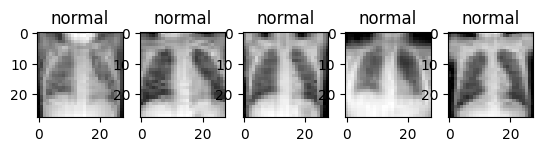

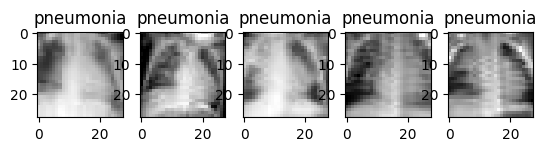

In [116]:
# normal images
plt.figure()
n = 0
for img, target in train_data_imgs:
    if int(target) == 0:
      plt.subplot(1, 5, n+1)
      plt.title("normal")
      plt.imshow(img, cmap='gray')
      n += 1
    if n >= 5:
      break
# pneumonia images
plt.figure()
n = 0
for img, target in train_data_imgs:
    if int(target) == 1:
      plt.subplot(1, 5, n+1)
      plt.title("pneumonia")
      plt.imshow(img, cmap='gray')
      n += 1
    if n >= 5:
      break

In [117]:
# TODO: Brighter spots around the chest.

PyTorch makes it easy to apply pre-processing transformations to the data, for example to normalize
the data prior to using for training. We will use the standard preprocessing functions to
*transform the images into tensors* for PyTorch to be able to use. This transformation also
changes the values to be floating-point numbers between 0 and 1.

In [118]:
import torchvision.transforms as transforms # contains a collection of transformations

train_data = PneumoniaMNIST(split='train', download=True, transform=transforms.ToTensor())
val_data = PneumoniaMNIST(split='val', download=True, transform=transforms.ToTensor())
test_data = PneumoniaMNIST(split='test', download=True, transform=transforms.ToTensor())

for img, target in train_data:
    print(img)    # img is a PyTorch tensor fo shape 1x28x28
    print(target) # the target
    break

Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
tensor([[[0.3608, 0.4235, 0.4588, 0.4353, 0.3961, 0.3529, 0.2745, 0.1922,
          0.1098, 0.2353, 0.3255, 0.4667, 0.6118, 0.7294, 0.8275, 0.8000,
          0.7529, 0.7961, 0.8000, 0.6510, 0.4510, 0.3529, 0.2078, 0.0000,
          0.0000, 0.0196, 0.0314, 0.0235],
         [0.5059, 0.5412, 0.5529, 0.5176, 0.4706, 0.4353, 0.3922, 0.3490,
          0.3804, 0.4314, 0.4118, 0.4588, 0.5647, 0.6784, 0.7647, 0.7098,
          0.7608, 0.7569, 0.6980, 0.5569, 0.4314, 0.3608, 0.2235, 0.0431,
          0.0235, 0.0157, 0.0078, 0.0118],
         [0.5529, 0.5725, 0.5804, 0.5608, 0.5255, 0.5020, 0.4941, 0.4941,
          0.5490, 0.6118, 0.5608, 0.5373, 0.5647, 0.6353, 0.7059, 0.6471,
          0.6235, 0.6510, 0.6078, 0.5294, 0.4941, 0.4314, 0.3098, 0.2157,
          0.0314, 0.0000, 0.0000, 0

**Task**: How many X-ray images are in the training set *with* pneumonia? What about *without* pneumonia?
What about the validation/test sets?
What does your answer say about the data balance?

In [119]:
# TODO: With pneumonia = 3494, without = 1214. The details prior are for the training set.
# For validation w = 389, w/o = 135. For test w = 390, w/o = 234.
# It seems like we have a lot more data of patients with pneumonia vs w/o pneumonia.

## Part 2. Model and Training

We will build our own PyTorch model, which will be a subclass of `nn.Module`.
This subclass provides the important methods that we used in the training loop
in lab 1, including the methods that allow us to compute the forward pass
by calling the model object, and other methods used under the hood to compute
the backward pass.

Our model will be a three-layer MLP with the following architecture:
ACTUALTODO---the model architecture may change!

In [120]:
import torch
import torch.nn as nn
import torch.optim as optim

class MLPModel(nn.Module):
    """A three-layer MLP model for binary classification"""
    def __init__(self, input_dim=28*28, num_hidden=100):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, num_hidden)
        self.fc2 = nn.Linear(num_hidden, num_hidden)
        self.fc3 = nn.Linear(num_hidden, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

**Graded Task**: How many trainable parameters are in this model?
Express your answer in terms of `input_dim` and `num_hidden`.

In [121]:
# TODO: Trainable parametres are the weights and biases. As a result we have the following:
# First layer: Weights = input_dim*num_hidden, Biases = num _hidden
# Second Layer: Weights = num_hidden*num_hidden, Biases = num_hidden
# Third Layer: Weights = num_hidden, Biases = 1
# Total = 88701, Expression = (input_dim×num_hidden)+(num_hidden^2)+(3×num_hidden)+1

In order to assess model performance, we will begin by
implementing the `accuracy` function, which computes the accuracy
of the model across a dataset.

**Graded Task**: Complete the `accuracy` function. Keep in mind
that this function will be slightly different from the `accuracy`
function in lab 1, since we are working on a binary classification
problem and prediction here is a single logit value (rather than
a vector).

In [122]:
def accuracy(model, dataset):
    """
    Compute the accuracy of `model` over the `dataset`.
    We will take the **most probable class**
    as the class predicted by the model.

    Parameters:
        `model` - A PyTorch MLPModel
        `dataset` - A data structure that acts like a list of 2-tuples of
                  the form (x, t), where `x` is a PyTorch tensor of shape
                  [1, 28, 28] representing an MedMNIST image,
                  and `t` is the corresponding binary target label

    Returns: a floating-point value between 0 and 1.
    """

    correct, total = 0, 0
    loader = torch.utils.data.DataLoader(dataset, batch_size=100)
    for img, t in loader:
        X = img.reshape(-1, 784)
        z = model(X)
        probabilities = torch.sigmoid(z)
        y = (probabilities >= 0.5).float() # The thershold value is set to 0.5, then converted to numerical values instead of boolean.
        # TODO: pred should be a [N, 1] tensor with binary
        # predictions, (0 or 1 in each entry)

        correct += int(torch.sum(t == y))
        total   += t.shape[0]
    return correct / total

Because we are working with binary classification, we will be using a
different implementation of the cross-entropy loss function, implemented
via PyTorch in a class called `BCEWithLogitsLoss` (short for
Binary Cross Entropy with Logits loss).

In [123]:
criterion = nn.BCEWithLogitsLoss()

This loss function takes a predicted logit (pre-softmax activation)
and the ground-truth label.
The use of pre-softmax logits rather than prediction probabilities is
due to numerical stability reasons.

In [124]:
print(criterion(torch.tensor([2.5]),  # predicted
                torch.tensor([1.])))  # actual

print(criterion(torch.tensor([-2.5]), # predicted
                torch.tensor([1.])))  # actual

tensor(0.0789)
tensor(2.5789)


**Task**: Explain why the second printed
value above is *larger* than the first. In other words,
why does it make sense that we think of the second prediction
(logit of z=-2.5) as "worse" than the first (logit of z=2.5)?

In [125]:
# TODO: This is due to the nature of the sigmoid functions. Negative logits results in a probability that is closer
# to 0. Thefore indicating a greater difference from the actual target and as a result giving us a larger difference.

**Graded Task**: Complete the following code to be used for training.

50 Loss: 0.48189765214920044 Train Acc: 0.7421410365335599 Val Acc: 0.7423664122137404
100 Loss: 0.5559835433959961 Train Acc: 0.887213254035684 Val Acc: 0.8759541984732825
150 Loss: 0.2842388451099396 Train Acc: 0.8381478334749363 Val Acc: 0.8187022900763359
200 Loss: 0.32569998502731323 Train Acc: 0.9025063721325404 Val Acc: 0.9007633587786259
250 Loss: 0.26157790422439575 Train Acc: 0.8855140186915887 Val Acc: 0.8759541984732825
300 Loss: 0.21121710538864136 Train Acc: 0.9239592183517417 Val Acc: 0.9389312977099237
350 Loss: 0.1823551207780838 Train Acc: 0.907179269328802 Val Acc: 0.9045801526717557
400 Loss: 0.20874790847301483 Train Acc: 0.9222599830076466 Val Acc: 0.9198473282442748
450 Loss: 0.21227872371673584 Train Acc: 0.9265080713678845 Val Acc: 0.9293893129770993


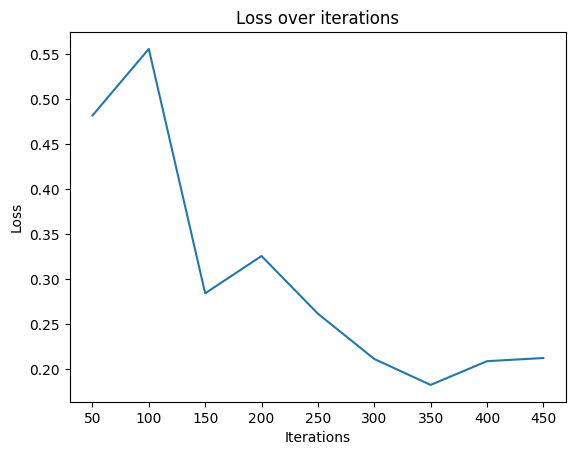

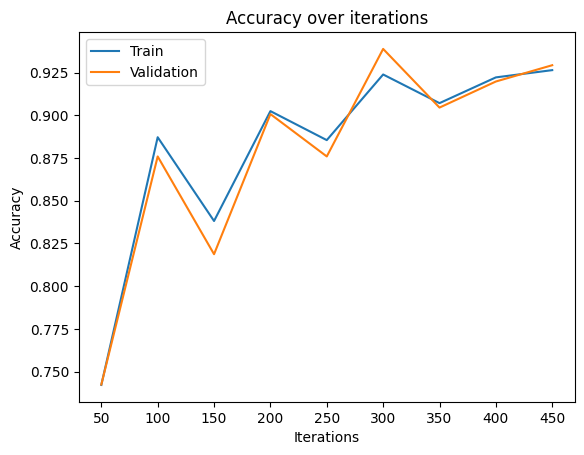

In [126]:
def train_model(model,                # an instance of MLPModel
                train_data,           # training data
                val_data,             # validation data
                learning_rate=0.1,
                batch_size=100,
                num_epochs=10,
                plot_every=50,        # how often (in # iterations) to track metrics
                plot=True):           # whether to plot the training curve
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               shuffle=True) # reshuffle minibatches every epoch
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # these lists will be used to track the training progress
    # and to plot the training curve
    iters, train_loss, train_acc, val_acc = [], [], [], []
    iter_count = 0 # count the number of iterations that has passed

    try:
        for e in range(num_epochs):
            for i, (images, labels) in enumerate(train_loader):
                z = model(images.reshape(-1, 784)) # TODO
                loss = criterion(z, labels.float()) # TODO

                loss.backward() # propagate the gradients
                optimizer.step() # update the parameters
                optimizer.zero_grad() # clean up accumualted gradients

                iter_count += 1
                if iter_count % plot_every == 0:
                    iters.append(iter_count)
                    ta = accuracy(model, train_data)
                    va = accuracy(model, val_data)
                    train_loss.append(float(loss))
                    train_acc.append(ta)
                    val_acc.append(va)
                    print(iter_count, "Loss:", float(loss), "Train Acc:", ta, "Val Acc:", va)
    finally:
        # This try/finally block is to display the training curve
        # even if training is interrupted
        if plot:
            plt.figure()
            plt.plot(iters[:len(train_loss)], train_loss)
            plt.title("Loss over iterations")
            plt.xlabel("Iterations")
            plt.ylabel("Loss")

            plt.figure()
            plt.plot(iters[:len(train_acc)], train_acc)
            plt.plot(iters[:len(val_acc)], val_acc)
            plt.title("Accuracy over iterations")
            plt.xlabel("Iterations")
            plt.ylabel("Accuracy")
            plt.legend(["Train", "Validation"])

# Please include the output of this cell for grading
model = MLPModel()
train_model(model, train_data, val_data)

**Task**: Suppose that a model has a validation accuracy of 74% for this
binary classification task. Why would this model be considered a very bad model?
Your answer should illustrate why accuracy may not be an excellent tool to use.

In [127]:
# TODO: Acuracy is a measure of (Correct Predictions/All Predictions). Given the imbalanced dataset that we have present
# the model could likely be correctly identifying only the positive cases and as a result not learning how to identify
# the incorrect cases.

## Part 3. Performance Metrics

We often use accuracy as a go-to metric when evaluating the performance of
a classification model. However, the accuracy measure weighs all errors equally.
A deeper look into the types of errors made can provide a more complete picture
of model performance, especially when there is data imbalance and---when applying
models in real situations---when some errors may be associated with more serious
impacts to users than others.

To start our explorations, we'll look at the decisions we made well, i.e. the:

- True Positives (TP), or positive outcomes that were correctly predicted as positive.
- True Negatives (TN), or negative outcomes that were correctly predicted as negative.

Then we will look at our mistakes, i.e. the:

- False Positives (FP, or Type I errors), or negative outcomes that were predicted as positive. In our case, this occurs when our model predicts that a person has heart disease, but they do not.
- False Negatives (FN, or Type II errors), or positive outcomes that were predicted as negative. In our case, this occurs when our model predicts that a person does not have heart disease, but they do.

We can then use the metrics above to calculate:

- Precision (or True Positive Rate, or Positive Predicive Value): $\frac{TP}{TP + FP}$. The answers the question: out of all the examples that we predicted as positive, how many are really positive?
- Recall (or Sensitivity): $\frac{TP}{TP + FN}$. The answers the question: out of all the positive examples in the data set, how many did we predict as positive?
- Negative Predicive Value: $\frac{TN}{TN + FN}$. The answers the question: out of all the examples that we predicted as negative, how many are really negative?

Note that there are many metrics with subtly different meanings and interpretations. Make sure to be precise in what you present and why!

**Graded Task**: Complete the functions `precision` and `recall`:

In [128]:
def precision(model, dataset):
    """
    Compute the precision of `model` over the `dataset`.  We will take the
    **most probable class** as the class predicted by the model.

    Parameters:
        `model` - A PyTorch MLPModel
        `dataset` - A data structure that acts like a list of 2-tuples of
                  the form (x, t), where `x` is a PyTorch tensor of shape
                  [1, 28, 28] representing an MedMNIST image,
                  and `t` is the corresponding binary target label

    Returns: a floating-point value between 0 and 1.
    """
    true_pos, total_pred_pos = 0, 0
    loader = torch.utils.data.DataLoader(dataset, batch_size=100)
    for img, t in loader:
        X = img.reshape(-1, 784)
        z = model(X)

        probabilities = torch.sigmoid(z)
        y = (probabilities >= 0.5).float() # TODO: pred should be a [N, 1] tensor with binary
                    # predictions, (0 or 1 in each entry)
        true_pos = (t == y).sum()
        total_pred_pos = y.sum()
        # TODO: update total_pred_pos and true_pos
    return true_pos / total_pred_pos


def recall(model, dataset):
    """
    Compute the recall (or sensitivity) of `model` over the `dataset`.  We will
    take the **most probable class** as the class predicted by the model.

    Parameters:
        `model` - A PyTorch MLPModel
        `dataset` - A data structure that acts like a list of 2-tuples of
                  the form (x, t), where `x` is a PyTorch tensor of shape
                  [1, 28, 28] representing an MedMNIST image,
                  and `t` is the corresponding binary target label

    Returns: a floating-point value between 0 and 1.
    """
    true_pos, total_actual_pos = 0, 0 # track the true and false positive
    loader = torch.utils.data.DataLoader(dataset, batch_size=100)
    for img, t in loader:
        X = img.reshape(-1, 784)
        z = model(X)

        probabilities = torch.sigmoid(z)
        y = (probabilities >= 0.5).float() # TODO: pred should be a [N, 1] tensor with binary
                    # predictions, (0 or 1 in each entry)
        true_pos = (t == y).sum()
        total_actual_pos = t.sum()
        # TODO: update total_pos and true_pos
    return true_pos / total_actual_pos

print("Precision(Training)", precision(model, train_data))
print("Recall(Training)", recall(model, train_data))
print("Precision(Validation)", precision(model, val_data))
print("Recall(Validation)", recall(model, val_data))

Precision(Training) tensor(1.)
Recall(Training) tensor(1.)
Precision(Validation) tensor(1.3529)
Recall(Validation) tensor(1.2778)


A **confusion matrix** is a table that shows the number of TP, TN, FP, and FN.  A confusion matrix can be a valuable tool in understanding
why a model makes the mistake that it makes.

**Task** Run the code below to display the confusion matrix for your model
for the validation data.

Text(0.5, 1.0, 'Confusion Matrix (Val Data)')

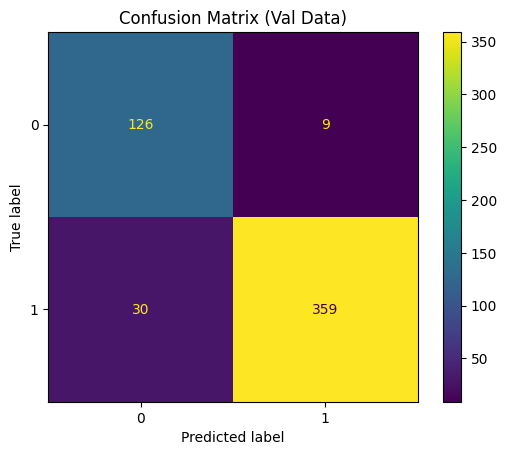

In [129]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def get_prediction(model, data, sample=1000):
    loader = torch.utils.data.DataLoader(data, batch_size=sample, shuffle=True)
    for X, t in loader:
        z = model(X.view(-1, 784))
        y = torch.sigmoid(z)
        break
    y = y.detach().numpy()
    t = t.detach().numpy()
    return y, t

y, t = get_prediction(model, val_data)
y = y > 0.5
cm = confusion_matrix(t, y)
cmp = ConfusionMatrixDisplay(cm, display_labels=["0", "1"])
cmp.plot()
plt.title("Confusion Matrix (Val Data)")

**Task**: The code below trains a MLPModel for a very few number
of iterations. You should see that this model achieves a 74% accuracy.
Display the confusion matrix for this model by running the code below.

Training Accuracy: 0.7421410365335599
Validation Accuracy: 0.7423664122137404


Text(0.5, 1.0, 'Confusion Matrix (Val Data)')

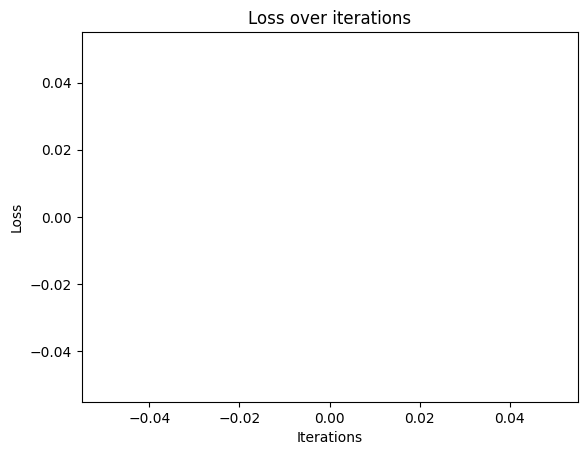

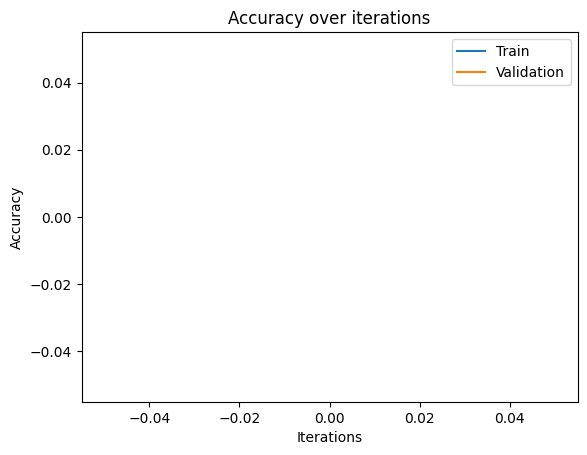

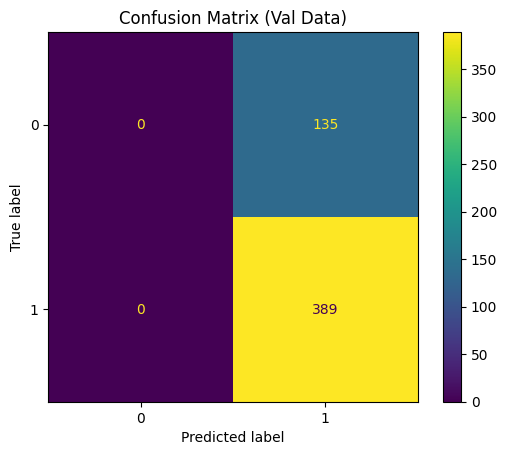

In [130]:
m_once = MLPModel()
train_model(m_once, train_data, val_data, learning_rate=0.5, batch_size=500, num_epochs=1)
print("Training Accuracy:", accuracy(m_once, train_data))
print("Validation Accuracy:", accuracy(m_once, val_data))

y, t = get_prediction(m_once, val_data)
y = y > 0.5
ConfusionMatrixDisplay(confusion_matrix(t, y), display_labels=["0", "1"]).plot()
plt.title("Confusion Matrix (Val Data)")

**Graded Task**: What does the confusion matrix tell you about how
the `m_once` model is achieving 74% accuracy?

In [131]:
# TODO: It shows that the 74% accuracy is coming from the model classifying all the inputs as true. This shows that
# the accuracy metric isn't a fair assessment of how useful the model actually is and that the biased dataset is affecting
# how well it actually performs. Since most of the data is of patients with Pneumonia the model can receive an accuracy of
# 74% purely from guessing all the data (in this batch) as True.

We have been choosing a threshold of 0.5 for turning our continuous predicted
probabilities into a discrete prediction. However, this can be an
arbitrary choice.

**Task**: Note that we looked at the sign of the logits at the beginning of the notebook, and are now using a threshold of 0.5. Think about what relationship these two values (0 and 0.5) have. How do you obtain one from the other?

In [132]:
# TODO: Your explanation goes here.

**Task**: Explain why, in practical application, it may be reasonable to use a different
threshold value. In what situation might you want the threshold to be set
very high in order to make a positive prediction? What about a negative prediction?

In [133]:
# TODO: Your explanation goes here.
# We would set high thresholds for situations in which a false positive could be dangerous. For example, accidentally
# sentencing someone to several years in prison

# We would set high thresholds for a negative prediction in examples where we might not want to spread a virus.

A **receiver operating characteristic curve** (or ROC) shows how the True Positive Rate and False Positive Rate vary based on our choice of the decision making threshold used to binarize predictions.  By default, this threshold is 0.5, but it can be changed to any value between 0 and 1. Different thresholds will result in different TP and FP rates, all of which are illustrated on our graph. we can calculate the area underneath this curve in order to get a sense as to how our classifiers might work across a wide range of different thresholds. This calcution of area can also be used as a metric of our model's "goodness", and it is called AUC (or "Area Under Curve").

The AUC metric is particularly useful for machine learning practitioners
because it does *not* depend on the choice of the threshold value used
for making discrete predicions. The metric is also resistant to
measurement.

**Task**: Is it better for the AUC to be larger or smaller? Explain why.

In [134]:
# TODO: Its better for the AUC to be larger, this implies that its possible for us to correctly identify positive data points
# while minimising incorrectly identifying negative data points.

The code below plots the ROC curve for a model.

Text(0.5, 1.0, 'Training ROC Curve')

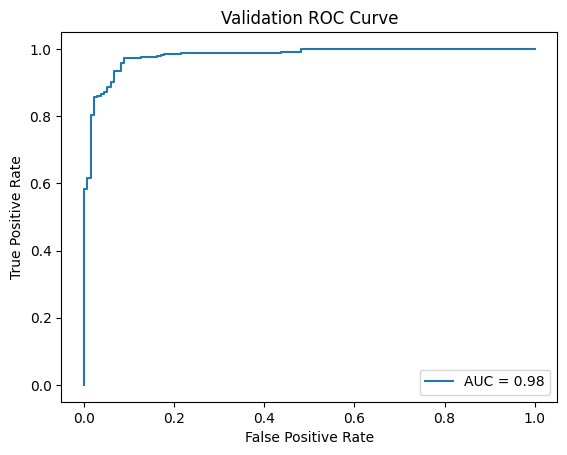

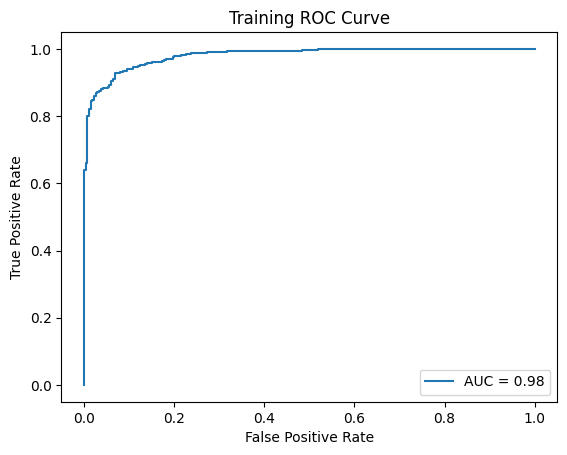

In [135]:
from sklearn.metrics import roc_curve, RocCurveDisplay, auc

y, t = get_prediction(model, val_data)

fpr, tpr, thresholds = roc_curve(t, y)
roc_auc = auc(fpr, tpr)
rocp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
rocp.plot()
plt.title("Validation ROC Curve")


y, t = get_prediction(model, train_data)

fpr, tpr, thresholds = roc_curve(t, y)
roc_auc = auc(fpr, tpr)
rocp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
rocp.plot()
plt.title("Training ROC Curve")

Here is a function you can use to estimate the auc:

In [136]:
def get_auc(model, data):
    y, t = get_prediction(model, data)
    fpr, tpr, thresholds = roc_curve(t, y)
    return auc(fpr, tpr)

## Part 4. Hyperparameter Tuning via Grid Search

As we mentioned in lab 1, hyperparameter choices matter significantly,
and these hyperparameter choices interact with one another.
Practitioners use a strategy called **grid search** to try
all variations of hyperparameters from a set of hyperparameters.

One very important hyperparameter is the number of hidden units in our MLPModel.
This setting affects the number of parameters (weights/biases) used in our model.

The use of ReLU vs sigmoid activation function is another hyperparameter that we
will explore.

Finally, optimization parameters like the batch size and the learning rate can
also significantly affect the learning process.

In [137]:
class MLPModelSigmoid(nn.Module):
    """A three-layer MLP model for binary classification"""
    def __init__(self, input_dim=28*28, num_hidden=100):
        super(MLPModelSigmoid, self).__init__()
        self.fc1 = nn.Linear(input_dim, num_hidden)
        self.fc2 = nn.Linear(num_hidden, num_hidden)
        self.fc3 = nn.Linear(num_hidden, 1)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.sig(out)
        out = self.fc2(out)
        out = self.sig(out)
        out = self.fc3(out)
        return out

**Graded Task**: Complete the code below, which performs grid search over the following hyperparameter
values of the:

- hidden size
- activation function (ReLu vs sigmoid activation)
- batch size
- learning rate

Do so by creating a new model and train it with the appropriate
settings, then assessing the final training/validation accuracy,
precision, recall, and AUC score. You may use to use
the flag `plot=False` when calling `train_model`. You might
also set `plot_every` to a large value and visualize the
training curve as a separate step for hyperparameter values
that you're interested in.

Please include all your output in your submission.

(There is one more graded task below that you can complete while the
hyperparameter tuning is running.)

In [138]:
gridsearch = {}
for num_hidden in [25, 100, 250]:
    for act in ["relu", "sigmoid"]:
        for bs in [10, 100, 500]:
            for lr in [0.01, 0.1]:
                # Adjust num_epoch based on the batch size, so that we
                # train for the same number of iterations irrespective
                # of batch size
                ne = int(20 * (bs/100))

                modelname = f"num_hidden: {num_hidden}, activation: {act}, batch_size: {bs}, learning_rate: {lr}"
                print(f"========={modelname}")

                # TODO: create and train the model with the appropriate settings
                if act == "relu":
                    m = MLPModel(input_dim=28*28, num_hidden=num_hidden)

                elif act == "sigmoid":
                    m = MLPModelSigmoid(input_dim=28*28, num_hidden=num_hidden)

                train_model(m, train_data, val_data, learning_rate=lr, batch_size=bs, num_epochs=ne, plot=False, plot_every=1000)

                # Update and display metrics. This part is done for you.
                metrics = {
                    "acc_train": accuracy(m, train_data),
                    "acc_val": accuracy(m, val_data),
                    "precision_train": precision(m, train_data),
                    "precision_val": precision(m, val_data),
                    "recall_train": recall(m, train_data),
                    "recall_val": recall(m, val_data),
                    "auc_train": get_auc(m, train_data),
                    "auc_val": get_auc(m, val_data),
                }
                gridsearch[modelname] = metrics
                print(f'Accuracy (train):{metrics["acc_train"]} (val):{metrics["acc_val"]}')
                print(f'Precision (train):{metrics["precision_train"]} (val):{metrics["precision_val"]}')
                print(f'Recall (train):{metrics["recall_train"]} (val):{metrics["recall_val"]}')
                print(f'AUC (train):{metrics["auc_train"]} (val):{metrics["auc_val"]}')

=========num_hidden: 25, activation: relu, batch_size: 10, learning_rate: 0.01
Accuracy (train):0.9177994902293968 (val):0.9274809160305344
Precision (train):1.0 (val):1.3529411554336548
Recall (train):1.0 (val):1.2777777910232544
AUC (train):0.9752539302581354 (val):0.9733599923831286
=========num_hidden: 25, activation: relu, batch_size: 10, learning_rate: 0.1
Accuracy (train):0.9050552251486831 (val):0.9026717557251909
Precision (train):0.75 (val):1.2105263471603394
Recall (train):1.0 (val):1.2777777910232544
AUC (train):0.9636840125391849 (val):0.9709130724554889
=========num_hidden: 25, activation: relu, batch_size: 100, learning_rate: 0.01
Accuracy (train):0.8946474086661003 (val):0.8893129770992366
Precision (train):0.75 (val):1.2105263471603394
Recall (train):1.0 (val):1.2777777910232544
AUC (train):0.9688338694146811 (val):0.966200133295249
=========num_hidden: 25, activation: relu, batch_size: 100, learning_rate: 0.1
Accuracy (train):0.9156754460492779 (val):0.921755725190839

Please include the below output in your submission

In [139]:
print(gridsearch)

{'num_hidden: 25, activation: relu, batch_size: 10, learning_rate: 0.01': {'acc_train': 0.9177994902293968, 'acc_val': 0.9274809160305344, 'precision_train': tensor(1.), 'precision_val': tensor(1.3529), 'recall_train': tensor(1.), 'recall_val': tensor(1.2778), 'auc_train': 0.9752539302581354, 'auc_val': 0.9733599923831286}, 'num_hidden: 25, activation: relu, batch_size: 10, learning_rate: 0.1': {'acc_train': 0.9050552251486831, 'acc_val': 0.9026717557251909, 'precision_train': tensor(0.7500), 'precision_val': tensor(1.2105), 'recall_train': tensor(1.), 'recall_val': tensor(1.2778), 'auc_train': 0.9636840125391849, 'auc_val': 0.9709130724554889}, 'num_hidden: 25, activation: relu, batch_size: 100, learning_rate: 0.01': {'acc_train': 0.8946474086661003, 'acc_val': 0.8893129770992366, 'precision_train': tensor(0.7500), 'precision_val': tensor(1.2105), 'recall_train': tensor(1.), 'recall_val': tensor(1.2778), 'auc_train': 0.9688338694146811, 'auc_val': 0.966200133295249}, 'num_hidden: 25, 

**Task**: Which hyperparameter choice is the "best"? You should base this answer on the
validation AUC. Use the other metrics as a guide to understand the kinds of predictions and mistakes
that your model is likely make.
Train a final model with those hyperparameter values.

In [140]:
# TODO

**Task**: Report the test accuracy and AUC for this model, and plot the confusion matrix over the test set.

In [141]:
# TODO

**Graded Task**: Explain why a model with high AUC may still
produce consistently poor predictions for a subset of the population.
You might find this article interesting: [Gender imbalance in medical imaging datasets produces biased classifiers for computer-aided diagnosis](https://www.pnas.org/doi/10.1073/pnas.1919012117); in particular,
Figure 1 shows how test AUC differs male/female patients depending on the training set used.

In [142]:
# A model with high AUC can produce poor predictions for a subset of the population due to various reasons.
# From imabalanced datasets to representation biases. As mentioned in the paper the results were due to gender imbalances
# in the medical image data sets. As a result this highlights the importance of having a balanced and representative
# dataset and the importance of model evaluation using the appropriate metrics. The results from the table also
# indicate how models trained on male/female data work better on diagnosing that specific data too.